# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


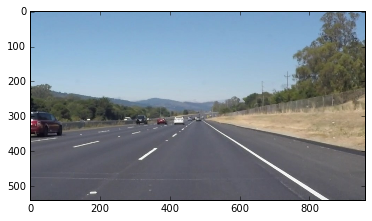

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def hsv_transform(img):
    """Applies the HSV transform"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # Define global variables for smoothing lines from frame to frame
    global left_x1_old
    global left_x2_old
    global left_y1_old
    global left_y2_old
    global right_x1_old
    global right_x2_old
    global right_y1_old
    global right_y2_old
    alpha = 0.4
    
    # Initialize global y_min and y_max values for our lines
    y_min = image.shape[0]
    y_max = image.shape[0]
    # Define lists to hold the separated left and right lines
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    # Define lists to hold the slopes of the left and right lines
    left_slopes = []
    right_slopes = []
    # Iterate over detected lines and separate into left and right lines based on slope
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Identify global y_min
            y_min = min(y_min, y1, y2)
            # Calculate slope of line
            slope = (y2-y1)/(x2-x1)
            # Separate lines into left and right based on slope value
            if -0.8 < slope < -0.4: # left lanes will have negative slope
                left_slopes.append(slope)
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
            elif 0.8 > slope > 0.4: # right lines will have positive slope
                right_slopes.append(slope)
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
    
    # Test if we have detected left lines within the slope thresholds
    if len(left_slopes) > 0:
        # Find the average slope and x and y points for left lines
        left_slope_avg = sum(left_slopes)/len(left_slopes)
        left_x_avg = sum(left_x)/len(left_x)
        left_y_avg = sum(left_y)/len(left_y)
        # Find y-intercept for left line avg
        left_y_intercept = left_y_avg - (left_slope_avg*left_x_avg)
        # Find left_x1 and left_x2 to draw the left line
        left_x1 = (y_min - left_y_intercept)/left_slope_avg
        left_x2 = (y_max - left_y_intercept)/left_slope_avg
        # If old values aren't yet saved use current values, else use weighted avg from last frame
        if 'left_x1_old' in vars() or 'left_x1_old' in globals():
            left_x1 = math.floor(alpha*left_x1_old + (1-alpha)*left_x1)
            left_x2 = math.floor(alpha*left_x2_old + (1-alpha)*left_x2)
            y_min = math.floor(alpha*left_y1_old + (1-alpha)*y_min)
            y_max = math.floor(alpha*left_y2_old + (1-alpha)*y_max)
            cv2.line(img, (int(left_x1), y_min), (int(left_x2), y_max), color, thickness)
        else:
            cv2.line(img, (int(left_x1), y_min), (int(left_x2), y_max), color, thickness)   
        # Update old values for next frame
        left_x1_old = left_x1
        left_x2_old = left_x2
        left_y1_old = y_min
        left_y2_old = y_max
    else:
        if 'left_x1_old' in vars() or 'left_x1_old' in globals():
            cv2.line(img, (int(left_x1_old), left_y1_old), (int(left_x2_old), left_y2_old), color, thickness)
    
    # Test if we have detected right lines within the slope thresholds
    if len(right_slopes) > 0:
        # Find the average slope and x and y points for right lines
        right_slope_avg = sum(right_slopes)/len(right_slopes)
        right_x_avg = sum(right_x)/len(right_x)
        right_y_avg = sum(right_y)/len(right_y)
        # Find y-intercept for left line avg
        right_y_intercept = right_y_avg - (right_slope_avg*right_x_avg)
        # Find left_x1 and left_x2 to draw the left line
        right_x1 = (y_min - right_y_intercept)/right_slope_avg
        right_x2 = (y_max - right_y_intercept)/right_slope_avg
        # If old values aren't yet saved use current values, else use weighted avg from last frame
        if 'right_x1_old' in vars() or 'right_x1_old' in globals():
            right_x1 = math.floor(alpha*right_x1_old + (1-alpha)*right_x1)
            right_x2 = math.floor(alpha*right_x2_old + (1-alpha)*right_x2)
            y_min = math.floor(alpha*right_y1_old + (1-alpha)*y_min)
            y_max = math.floor(alpha*right_y2_old + (1-alpha)*y_max)
            cv2.line(img, (int(right_x1), y_min), (int(right_x2), y_max), color, thickness)
        else:
            cv2.line(img, (int(right_x1), y_min), (int(right_x2), y_max), color, thickness)
        # Update old values for next frame
        right_x1_old = right_x1
        right_x2_old = right_x2
        right_y1_old = y_min
        right_y2_old = y_max
    else:
        if 'right_x1_old' in vars() or 'right_x1_old' in globals():
            cv2.line(img, (int(right_x1_old), right_y1_old), (int(right_x2_old), right_y2_old), color, thickness)
                

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # Make sure all images are same size
    image = cv2.resize(image, (960, 540))
    
    # Apply HSV transform
    hsv = hsv_transform(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(hsv, kernel_size)
    
    # Define threshold parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Define a four sided polygon to mask and create masked image
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450,320),(490,320),(imshape[1],imshape[0])]],dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 150 # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 # minimum number of pixels making up a line
    max_line_gap = 20 # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # create a blank to draw lines on
    
    # Run Hough on edge detected image
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Draw lines on original image
    result = weighted_img(lines, image)

    return result

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteCurve_out.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteRight_out.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve2_out.jpg',
 'solidYellowCurve_out.jpg',
 'solidYellowLeft.jpg',
 'solidYellowLeft_out.jpg',
 'whiteCarLaneSwitch.jpg',
 'whiteCarLaneSwitch_out.jpg']

run your solution on all test_images and make copies into the test_images directory).

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


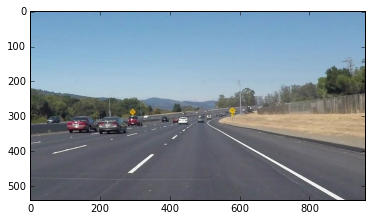

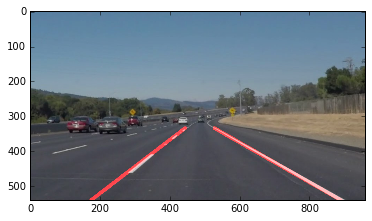

In [6]:
# reading in an image
swc = mpimg.imread('test_images/solidWhiteCurve.jpg')
# printing out some stats and plotting
print('This image is:', type(swc), 'with dimesions:', swc.shape)
# show before and after images
plt.figure()
plt.imshow(swc)
swc_out = process_image(swc)
plt.figure()
plt.imshow(swc_out)
# save image with lines drawn to test_images directory
mpimg.imsave('test_images/solidWhiteCurve_out.jpg', swc_out)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


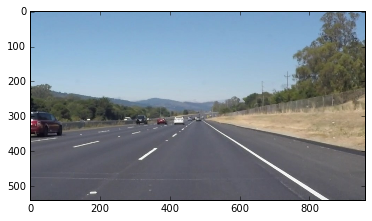

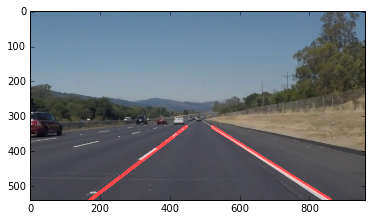

In [7]:
# reading in an image
swr = mpimg.imread('test_images/solidWhiteRight.jpg')
# printing out some stats and plotting
print('This image is:', type(swr), 'with dimesions:', swr.shape)
# show before and after images
plt.figure()
plt.imshow(swr)
swr_out = process_image(swr)
plt.figure()
plt.imshow(swr_out)
# save image with lines drawn to test_images directory
mpimg.imsave('test_images/solidWhiteRight_out.jpg', swr_out)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


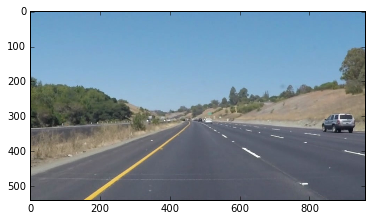

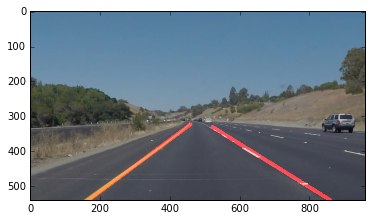

In [8]:
# reading in an image
syc = mpimg.imread('test_images/solidYellowCurve.jpg')
# printing out some stats and plotting
print('This image is:', type(syc), 'with dimesions:', syc.shape)
# show before and after images
plt.figure()
plt.imshow(syc)
syc_out = process_image(syc)
plt.figure()
plt.imshow(syc_out)
# save image with lines drawn to test_images directory
mpimg.imsave('test_images/solidYellowCurve_out.jpg', syc_out)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


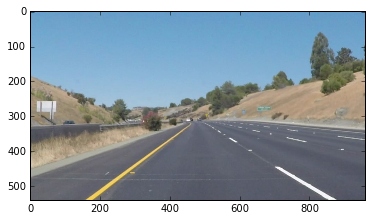

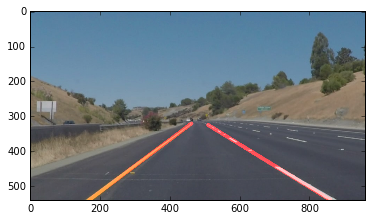

In [9]:
# reading in an image
syc2 = mpimg.imread('test_images/solidYellowCurve2.jpg')
# printing out some stats and plotting
print('This image is:', type(syc2), 'with dimesions:', syc2.shape)
# show before and after images
plt.figure()
plt.imshow(syc2)
syc2_out = process_image(syc2)
plt.figure()
plt.imshow(syc2_out)
# save image with lines drawn to test_images directory
mpimg.imsave('test_images/solidYellowCurve2_out.jpg', syc2_out)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


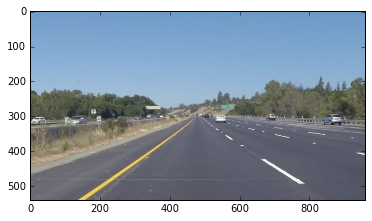

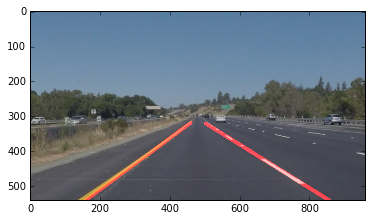

In [10]:
# reading in an image
syl = mpimg.imread('test_images/solidYellowLeft.jpg')
# printing out some stats and plotting
print('This image is:', type(syl), 'with dimesions:', syl.shape)
# show before and after images
plt.figure()
plt.imshow(syl)
syl_out = process_image(syl)
plt.figure()
plt.imshow(syl_out)
# save image with lines drawn to test_images directory
mpimg.imsave('test_images/solidYellowLeft_out.jpg', syl_out)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


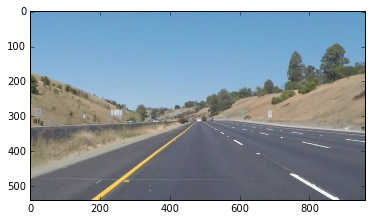

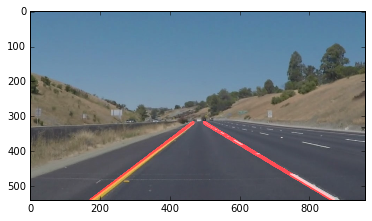

In [11]:
# reading in an image
wcls = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
# printing out some stats and plotting
print('This image is:', type(wcls), 'with dimesions:', wcls.shape)
# show before and after images
plt.figure()
plt.imshow(wcls)
wcls_out = process_image(wcls)
plt.figure()
plt.imshow(wcls_out)
# save image with lines drawn to test_images directory
mpimg.imsave('test_images/whiteCarLaneSwitch_out.jpg', wcls_out)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 36.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 8.75 s, sys: 1.75 s, total: 10.5 s
Wall time: 6.46 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:19<00:00, 35.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 26.8 s, sys: 5.3 s, total: 32.1 s
Wall time: 19.5 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

My pipeline does reasonably well on the test images, and this project has been a great experience. I've gone from having very little computer vision knowledge to being able to detect lane markers in an image in very little time, and it's very inspiring. However, I also realize that my solution is not very robust and creating a lane detection pipeline for a real car is much more complicated than my current solution. Some situations where my algorithm is likely to fail include navigating sharp turns, instances of cars in close proximity (especially cars directly in front of the car), cars changing into and out of the same lane, shadows on the road, roads with very faded lane markers, and night time driving or other different conditions such as rain or snow. My algorithm performs decent enough on the first two sample videos, but fails miserably on the 'Optional Challenge' video. One idea I have for making my algorithm perform better is taking an average of a few frames so that the lines are smoother from frame to frame. Another idea is to take a weighted average of the detected lines, giving more weight to lines closer to the car so that objects in the distance don't affect the slope of the drawn lines too much. I plan to continue working on my algorithm, experiment with some of my ideas, and address the issues presented in the 'Optional Challenge' video.

Update:
I've improved my algorithm enough so that it handles the 'Optional Challenge' video fairly well. Some of the changes I made include using an HSV transform instead of grayscale. Doing this allowed the algorithm to handle the shadows and different color stretches of road in the video. I also used a weighted average of the lines from the previous frame and the new frame so the drawn lines were smoother from frame to frame. In addition, I increased the threshold of the Hough Transform to reduce noise. Although still not perfect, these changes resulted in a more rubust pipeline which does well on all of the test images and videos presented here. 

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:07<00:00, 33.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 11.5 s, sys: 2.49 s, total: 14 s
Wall time: 7.86 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))